ดึงข้อมูล GPD, EPSย้อนหลัง เพื่อมา Predict set  
เอา gdp มาพยากรณ์ eps ด้วย regression  
สำเร็จแล้ว แล้วเอา forecast GDP มาเพื่อหา EPS  (เหมือน GDP เป็นยอดขายของประเทศ ดังนั้นก็เหมือนเอายอดขายมาพยากรณ์รายได้)  
หา forward pe เพื่อมาเป็นตัวตั้งหารกับ predicted EPS ก็จะได้ราคา:index  (รู้รายได้แล้วก็มาหาว่า เค้าจะเทรดกันที P/E กี่เท่า)

In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from datetime import timedelta

In [374]:
data_set_eps = pd.read_excel('../dataset/set_eps.xlsx', index_col= 'Date', parse_dates= True)
data_set = pd.read_excel('../dataset/set.xlsx', index_col= 'Date', parse_dates= True)
data_gdpq = pd.read_excel('../dataset/gdpq.xlsx', index_col= 'Date', parse_dates= True)

In [375]:
# กลับหัวท้าย data
df_set = data_set_eps[::-1]

In [377]:
df_set = df_set.dropna()

In [378]:
df_gdpq = data_gdpq

In [379]:
df = df_gdpq.join(df_set, how= 'outer')

# จะเห็นวันที่ทั้งหมดที่ na เมื่อเป็น Q

In [381]:
df[['Prior', 'Open', 'High', 'Low', 'Close', 'PE', 'EPS']] = df[['Prior', 'Open', 'High', 'Low', 'Close', 'PE', 'EPS']].fillna(method= 'ffill')

In [384]:
df = df.resample('Q', convention= 'end').asfreq()

In [405]:
df2 = df[['Close', 'PE', 'GDP', 'EPS']]

In [406]:
df2['EPS_pct_change'] = df2['EPS'].pct_change()
df2['EPS_pct_change'] = df2['EPS_pct_change'].shift(-1)
df2['GDP_pct_change'] = df2['GDP'].pct_change() 
df2['GDP_pct_change'] = df2['GDP_pct_change'].shift(-1) # เดี๋ยวลองแบบไม่ชิฟ
df2['Close_pct_change'] = df2['Close'].pct_change()
df2['Close_pct_change'] = df2['Close_pct_change'].shift(-1)

<ipython-input-406-074de1db3ef2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['EPS_pct_change'] = df2['EPS'].pct_change()
<ipython-input-406-074de1db3ef2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['EPS_pct_change'] = df2['EPS_pct_change'].shift(-1)
<ipython-input-406-074de1db3ef2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [409]:
df2.columns

Index(['Close', 'PE', 'GDP', 'EPS', 'EPS_pct_change', 'GDP_pct_change',
       'Close_pct_change'],
      dtype='object')

In [408]:
def pe(pe): # ชื่อ func pe และ args ใช้เป็น pe ที่ใส่เข้าไป
    if pe <= 5:
        return 1
    elif (pe > 5) & (pe <= 10):
        return 2
    elif (pe > 10) & (pe <= 20):
        return 3
    elif (pe > 20) & (pe <= 35):
        return 4
    elif (pe > 35) & (pe <= 50):
        return 5    
    else:
        return 6
### แก้ ค่า label pe
### ลอง end gdp ว่าบวก=1, -= 0

In [410]:
df2['enc_pe'] = df2['PE'].apply(pe)

In [412]:
df2.columns

Index(['Close', 'PE', 'GDP', 'EPS', 'EPS_pct_change', 'GDP_pct_change',
       'Close_pct_change', 'enc_pe'],
      dtype='object')

In [414]:
df2 = df2[['Close', 'PE', 'GDP', 'EPS_pct_change', 'GDP_pct_change', 'Close_pct_change', 'enc_pe', 'EPS']]

In [416]:
df2 = df2.dropna()

In [417]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22 entries, 2016-03-31 to 2021-06-30
Freq: Q-DEC
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Close             22 non-null     float64
 1   PE                22 non-null     float64
 2   GDP               22 non-null     float64
 3   EPS_pct_change    22 non-null     float64
 4   GDP_pct_change    22 non-null     float64
 5   Close_pct_change  22 non-null     float64
 6   enc_pe            22 non-null     int64  
 7   EPS               22 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 1.5 KB


In [418]:
X = df2.iloc[:18, :-1]
y = df2.iloc[:18, -1:]

In [421]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics

In [422]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [425]:
model = LinearRegression()
scores = cross_val_score(model, X, y, scoring='r2', cv=4)
scores

array([ 0.55483317, -1.52899725, -0.57088927, -0.37690872])

In [426]:
model = LinearRegression()
reg = model.fit(X_train, y_train)

In [427]:
y_pred = reg.predict(X_test)

In [428]:
reg.score(X_test, y_test)

0.4839546077421836

In [431]:
print("MAE = ",  metrics.mean_absolute_error(y_test,y_pred))
print("MSE = ",  metrics.mean_squared_error(y_test,y_pred))
print("RMSE = ", np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

MAE =  7.57449520736972
MSE =  132.39527731073335
RMSE =  11.50631467111574


In [433]:
live_data = reg.predict(df2.iloc[18:, :-1])

In [435]:
test = df2.iloc[18:]

In [436]:
test['pred'] = live_data

<ipython-input-436-28c92657f09a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = live_data


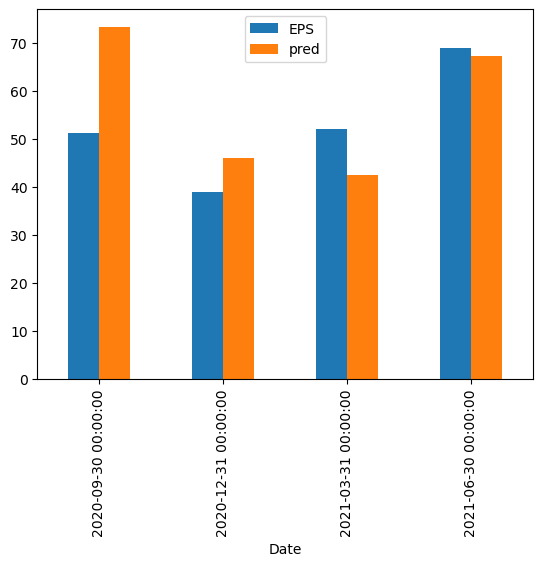

In [437]:
test.iloc[:, -2:].plot(kind= 'bar')
plt.show()